# Get change values from CMIP6 data

In [13]:
import numpy as np
import json
import os
import zipfile

# import a file
import xarray as xr

# create a land mask
import regionmask

from scipy import stats

import matplotlib.pyplot as plt

import geopandas as gpd
import matplotlib.pyplot as plt

import cdsapi
import os

import xarray as xr
import contextily as ctx
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import geometry
import pandas as pd
import os
import numpy as np

import json
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors


## collect CMIP6 data from Copernicus Climate Data Store

In [ ]:
# Download CMIP6 data from the CDS for selected region 

models = [
    "access_cm2", "access_esm1_5", "awi_cm_1_1_mr", "awi_esm_1_1_lr",
    "bcc_csm2_mr", "bcc_esm1", "cams_csm1_0", "canesm5",
    "canesm5_canoe", "cesm2", "cesm2_fv2", "cesm2_waccm",
    "cesm2_waccm_fv2", "ciesm", "cmcc_cm2_hr4", "cmcc_cm2_sr5",
    "cmcc_esm2", "cnrm_cm6_1", "cnrm_cm6_1_hr", "cnrm_esm2_1",
    "e3sm_1_0", "e3sm_1_1", "e3sm_1_1_eca", "ec_earth3",
    "ec_earth3_aerchem", "ec_earth3_cc", "ec_earth3_veg",
    "ec_earth3_veg_lr", "fgoals_f3_l", "fgoals_g3", "fio_esm_2_0",
    "gfdl_esm4", "giss_e2_1_g", "giss_e2_1_h", "hadgem3_gc31_ll",
    "hadgem3_gc31_mm", "iitm_esm", "inm_cm4_8", "inm_cm5_0",
    "ipsl_cm5a2_inca", "ipsl_cm6a_lr", "kace_1_0_g", "kiost_esm",
    "mcm_ua_1_0", "miroc6", "miroc_es2h", "miroc_es2l",
    "mpi_esm_1_2_ham", "mpi_esm1_2_hr", "mpi_esm1_2_lr", "mri_esm2_0",
    "nesm3", "norcpm1", "noresm2_lm", "noresm2_mm", "sam0_unicon",
    "taiesm1", "ukesm1_0_ll"
]

experiments = ['historical', 'ssp1_1_9','ssp1_2_6', 'ssp2_4_5','ssp3_7_0','ssp4_3_4', 'ssp4_6_0', 'ssp5_3_4os', 'ssp5_8_5']

variables = [ 'precipitation', 'near_surface_air_temperature', 'geopotential_height']

horizons = ['historical', '2021-2040', '2041-2060', '2081-2100']
uid = 12345 # your uid
apikey = '' # your apikey
zip_base_name = 'CMIP6_latvia'

c = cdsapi.Client(key=f"{uid}:{apikey}", url="https://cds.climate.copernicus.eu/api/v2")

temporal_resolution = 'daily' # monthly, daily


In [ ]:
def retrieve_data(temporal_resolution, horizon, experiment, variable, model, zip_base_name):
    if horizon == 'historical':
        years = [str(i) for i in range(1940, 2014)]
    elif horizon == '2021-2040':
        years = [str(i) for i in range(2021, 2041)]
    elif horizon == '2041-2060':
        years = [str(i) for i in range(2041, 2061)]
    elif horizon == '2081-2100':
        years = [str(i) for i in range(2081, 2100)]
    if variable in ['precipitation','near_surface_air_temperature']:
        return c.retrieve(
        'projections-cmip6',
        {
            'temporal_resolution': temporal_resolution,
            'experiment': experiment,
            'variable': variable,
            'model': model,
            'year': years,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'area': [
                62.45, 12.90, 52.45,34.15,
            ],
            'format': 'zip',
        }, f'data/CDS_cmip_latvia/zipped/{zip_base_name}_{temporal_resolution}_{horizon}_{experiment}_{variable}_{model}.zip')
    if variable == 'geopotential_height':
        return c.retrieve(
        'projections-cmip6',
        {
            'temporal_resolution': temporal_resolution,
            'experiment': experiment,
            'variable': variable,
            'model': model,
            'year': years,
            'level': '500',
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'area': [
                80, -55, 10,54, #71.5, -12, 35,54, # europe
            ],
            'format': 'zip',
        }, f'data/CDS_cmip_latvia/zipped/{zip_base_name}_{temporal_resolution}_{horizon}_{experiment}_{variable}_{model}.zip')

In [ ]:
list_of_failed_models = []
with open('failed_retrievals.txt', 'r') as f:
    for line in f:
        list_of_failed_models.append(line.strip())

In [ ]:
n=0
i=0
# retrieve data for all models, experiments, variables and horizons

for model in models:
    for experiment in experiments:
        for variable in variables:
            for horizon in horizons:
                try:
                    if variable == 'precipitation':
                        temporal_resolution = 'daily'
                    else:
                        temporal_resolution = 'monthly'
                    # if file does not yet exist, retrieve data
                    if not os.path.isfile(f'data/CDS_cmip_latvia/zipped/{zip_base_name}_{temporal_resolution}_{horizon}_{experiment}_{variable}_{model}.zip'):
                        # do not run failed models
                        if f"{model}, {experiment}, {variable}, {horizon}" in list_of_failed_models:
                            print(f"Skipping failed model {model}, {experiment}, {variable}, {horizon}")
                        else:
                            # do not run historical experiment for future horizons
                            if (experiment == 'historical' and horizon == 'historical') or (experiment != 'historical' and horizon != 'historical'):
                                
                                print(f"Retrieving data for {zip_base_name}_{temporal_resolution}_{horizon}_{experiment}_{variable}_{model}")
                                retrieve_data(temporal_resolution, horizon, experiment, variable, model, zip_base_name)
                                n+=1
                            else:
                                print(f"Skipping historical experiment for {zip_base_name}_{temporal_resolution}_{horizon}_{experiment}_{variable}_{model}")    
                    else:
                        print(f"File already exists for {zip_base_name}_{temporal_resolution}_{horizon}_{experiment}_{variable}_{model}")
                        i+=1
                except:
                    print(f"Failed to retrieve data for {model}, {experiment}, {variable}, {horizon}")
                    # add to list of failed retrievals
                    with open('failed_retrievals.txt', 'a') as f:
                        f.write(f"{model}, {experiment}, {variable}, {horizon}\n")

## Unzip downloaded files

In [45]:
unzip = True

if unzip:
    data_folder = 'data/CDS_cmip_latvia/zipped/'
    output_folder = 'data/CDS_cmip_latvia/unzipped/'

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        if filename.endswith(".zip"):
            # Extract the nc files from the zip
            with zipfile.ZipFile(data_folder + filename, 'r') as zip_ref:
                for member in zip_ref.namelist():
                    if member.endswith('.nc'):
                        # Define the new file name
                        new_file_name = output_folder + filename.replace('.zip', '.nc')
                        
                        # Check if the new file already exists
                        if not os.path.exists(new_file_name):
                            # Extract only .nc file to the output folder
                            zip_ref.extract(member, output_folder)
                            
                            # Rename the .nc file to match the zip file name
                            os.rename(output_folder + member, new_file_name)
                        else:
                            print(f"File {new_file_name} already exists. Skipping...")

File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_cams_csm1_0.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_canesm5.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_cnrm_esm2_1.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_ec_earth3.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_ec_earth3_veg_lr.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_fgoals_g3.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_gfdl_esm4.nc already exists. Skipping...
File data/CDS_cmip_latvia/unzipped/CMIP6_latvia_daily_2021-2040_ssp1_1_9_precipitation_ipsl_cm6

## Find correlation mask

In [2]:
# Load the data
ds = xr.open_dataset('./data/Latvia historic/latvia_monthly_precip_temp.nc')
ds = ds.sel(expver=1)

# add country borderes
countries_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# find lat lon bounds of ds
lon_min, lon_max = ds.longitude.min().values, ds.longitude.max().values
lat_min, lat_max = ds.latitude.min().values, ds.latitude.max().values

# create bbox
bbox = geometry.box(lon_min, lat_min, lon_max, lat_max)

plot_bounds_gdf = gpd.GeoDataFrame(geometry=[bbox])

countries_within_bounds = countries_gdf.overlay(plot_bounds_gdf, how='intersection')

basin_fn = "./data/plotting_files/basins.geojson"

# Add the basin boundaries
basin_gdf = gpd.read_file(basin_fn)
center = basin_gdf.centroid.values[0]

# find correlatioin of grid cells with basin center cell
# find the grid cell closest to the center of the basin
center_lat = center.y
center_lon = center.x

ds_center = ds.sel(latitude=center_lat, longitude=center_lon, method='nearest')
times_series_center_df  = pd.DataFrame(ds_center.tp.values, index=ds_center.time.values, columns=['precipitation'])
times_series_center_df['temperature'] = ds_center.t2m.values - 273.15

# drop last
times_series_center_df = times_series_center_df.drop(times_series_center_df.index[-1])

# check if file exists
if os.path.exists('./data/Latvia historic/monthly_correlation_temp_precip.nc'):
    correlation_da = xr.open_dataset('./data/Latvia historic/monthly_correlation_temp_precip.nc')
    print('correlation dataarray loaded from file')
else:
    correlation_da_precip = xr.DataArray( coords=[ds.latitude, ds.longitude], dims=['latitude', 'longitude'], name='corr_precip')
    correlation_da_temp = xr.DataArray(coords=[ds.latitude, ds.longitude], dims=['latitude', 'longitude'], name='corr_temp')

    # combine the two correlation dataarrays
    correlation_da = xr.merge([correlation_da_precip, correlation_da_temp])


    lat_nr = 0
    lat_total = len(ds.latitude)

    for lat in ds.latitude:
        lat_nr +=1
        for lon in ds.longitude:
            timeseries_cell = pd.DataFrame(ds.tp.sel(latitude=lat, longitude=lon).values, index=ds.time.values, columns=['precipitation'])
            timeseries_cell['temperature'] = ds.t2m.sel(latitude=lat, longitude=lon).values -273.15


            correlation_value_cell_precip = times_series_center_df['precipitation'].corr(timeseries_cell['precipitation'])
            correlation_value_cell_temp = times_series_center_df['temperature'].corr(timeseries_cell['temperature'])

            correlation_da['corr_precip'].loc[lat, lon] = correlation_value_cell_precip
            correlation_da['corr_temp'].loc[lat, lon] = correlation_value_cell_temp
        print(end='\x1b[2K') # ANSI sequence to clear the line where the cursor is located
        print(f"progress = {lat_nr/lat_total * 100} %", end="\r")


    # save the correlation dataarray
    correlation_da.to_netcdf('./data/Latvia historic/monthly_correlation_temp_precip.nc')


C:\Users\buskop\AppData\Local\Temp\ipykernel_13852\984215220.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\buskop\Anaconda3\envs\climaax\Lib\site-packages\geopandas\geodataframe.py:2451: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.overlay(
C:\Users\buskop\AppData\Local\Temp\ipykernel_13852\984215220.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = basin_gdf.centroid.values[0]


correlation dataarray loaded from file


[12.899999618530273, 52.45000076293945, 34.150001525878906, 61.45000076293945]


Text(0.5, 0.98, 'Monthly precipitation correlation with center gridcell of basin')

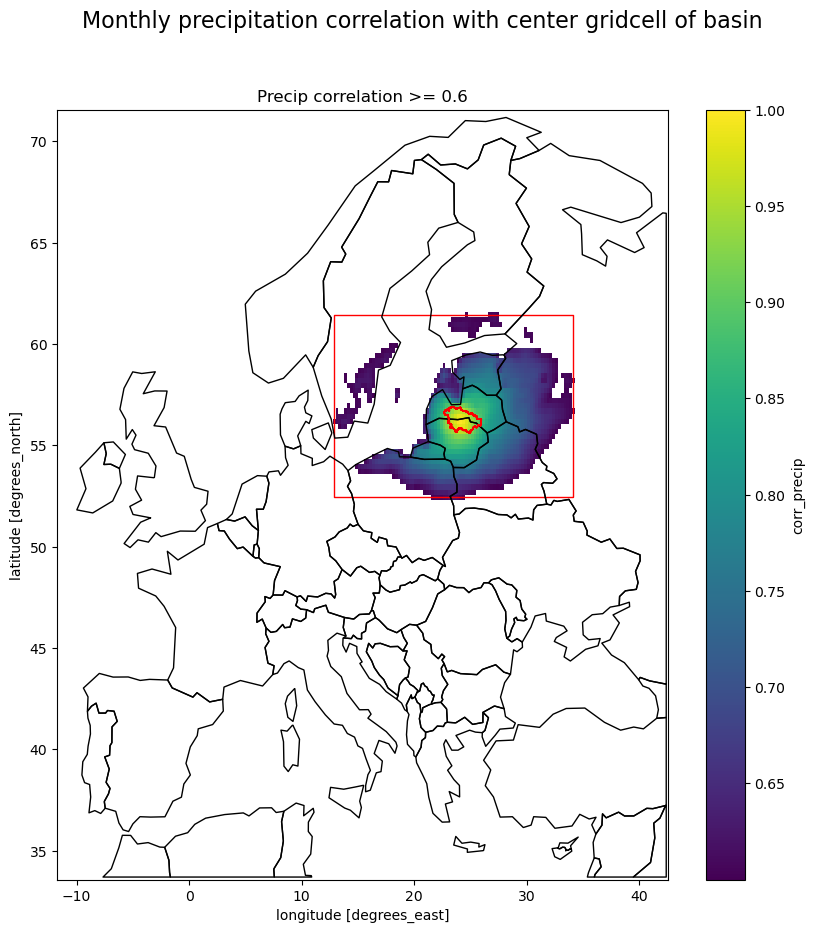

In [3]:
# plot the correlation values for different cut off values
corr_cutoff_value_precip = 0.6


corr_cutoff_precip = correlation_da['corr_precip'].where(correlation_da['corr_precip'] >corr_cutoff_value_precip)

# only keep cells where there are more than 10 the surrounding cells
corr_cutoff_precip = corr_cutoff_precip.where(corr_cutoff_precip.notnull().sum(dim=['latitude', 'longitude']) > 100)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
corr_cutoff_precip.plot(ax=ax)

# found bounds of the grid cells with correlation > cutoff
# drop cells where correlation is nan
corr_cutoff_precip = corr_cutoff_precip.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
lon_min, lon_max = corr_cutoff_precip.longitude.min().values, corr_cutoff_precip.longitude.max().values
lat_min, lat_max = corr_cutoff_precip.latitude.min().values, corr_cutoff_precip.latitude.max().values
# create bbox
bbox_precip = geometry.box(lon_min, lat_min, lon_max, lat_max)
bbox_gdf_precip = gpd.GeoDataFrame(geometry=[bbox_precip])
# plot bbox
bbox_gdf_precip.boundary.plot(ax=ax, color='red', linewidth=1)
# print bounds
print(f'[{lon_min}, {lat_min}, {lon_max}, {lat_max}]')



ax.set_title(f'Precip correlation >= {corr_cutoff_value_precip}')


countries_within_bounds.boundary.plot(ax=ax, color='black', linewidth=1)

# plot basin in red
basin_gdf.boundary.plot(ax=ax, color='red', linewidth=1)

# set title 
fig.suptitle('Monthly precipitation correlation with center gridcell of basin', fontsize=16)

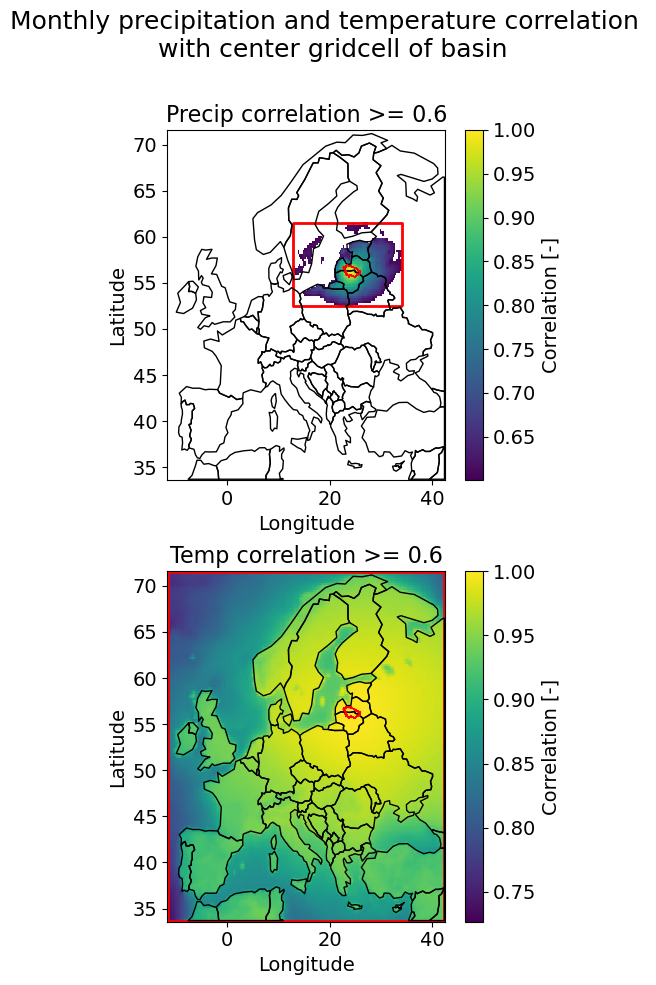

In [7]:

cutoff_values_precip = 0.6
cutoff_values_temp = 0.6

vertical = True

if vertical:
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
else:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))


corr_cutoff_precip = correlation_da['corr_precip'].where(correlation_da['corr_precip'] > cutoff_values_precip)
corr_cutoff_precip.plot(ax=ax[0])

corr_cutoff_temp = correlation_da['corr_temp'].where(correlation_da['corr_temp'] > cutoff_values_temp)
corr_cutoff_temp.plot(ax=ax[1])

# found bounds of the grid cells with correlation > cutoff
# drop cells where correlation is nan
corr_cutoff_precip = corr_cutoff_precip.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
lon_min, lon_max = corr_cutoff_precip.longitude.min().values, corr_cutoff_precip.longitude.max().values
lat_min, lat_max = corr_cutoff_precip.latitude.min().values, corr_cutoff_precip.latitude.max().values
# create bbox
bbox_precip = geometry.box(lon_min, lat_min, lon_max, lat_max)
bbox_gdf_precip = gpd.GeoDataFrame(geometry=[bbox_precip])
# plot bbox
bbox_gdf_precip.boundary.plot(ax=ax[0], color='red', linewidth=2)

corr_cutoff_temp = corr_cutoff_temp.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
lon_min, lon_max = corr_cutoff_temp.longitude.min().values, corr_cutoff_temp.longitude.max().values
lat_min, lat_max = corr_cutoff_temp.latitude.min().values, corr_cutoff_temp.latitude.max().values
# create bbox
bbox_temp = geometry.box(lon_min, lat_min, lon_max, lat_max)
bbox_gdf_temp = gpd.GeoDataFrame(geometry=[bbox_temp])
# plot bbox
bbox_gdf_temp.boundary.plot(ax=ax[1], color='red', linewidth=2)

ax[0].set_title(f'Precip correlation >= {cutoff_values_precip}')
ax[1].set_title(f'Temp correlation >= {cutoff_values_temp}')


countries_within_bounds.boundary.plot(ax=ax[0], color='black', linewidth=1)
countries_within_bounds.boundary.plot(ax=ax[1], color='black', linewidth=1)

# plot basin in red
basin_gdf.boundary.plot(ax=ax[0], color='red', linewidth=0.7)
basin_gdf.boundary.plot(ax=ax[1], color='red', linewidth=0.7)

# set title 
fig.suptitle(f'Monthly precipitation and temperature correlation \n with center gridcell of basin', fontsize=18)

# set all fontsizes
ax[0].set_title(f'Precip correlation >= {cutoff_values_precip}', fontsize=16)
ax[1].set_title(f'Temp correlation >= {cutoff_values_temp}', fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

ax[0].set_xlabel('Longitude', fontsize=14)
ax[0].set_ylabel('Latitude', fontsize=14)

ax[1].set_xlabel('Longitude', fontsize=14)
ax[1].set_ylabel('Latitude', fontsize=14)

# set color bar font size
cbar = ax[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Correlation [-]', fontsize=14)

cbar = ax[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Correlation [-]', fontsize=14)

plt.tight_layout()
# move the subplots down a bit
# delete bottom row

if vertical:
    plt.subplots_adjust(top=0.86)
else:
    plt.subplots_adjust(top=0.80)


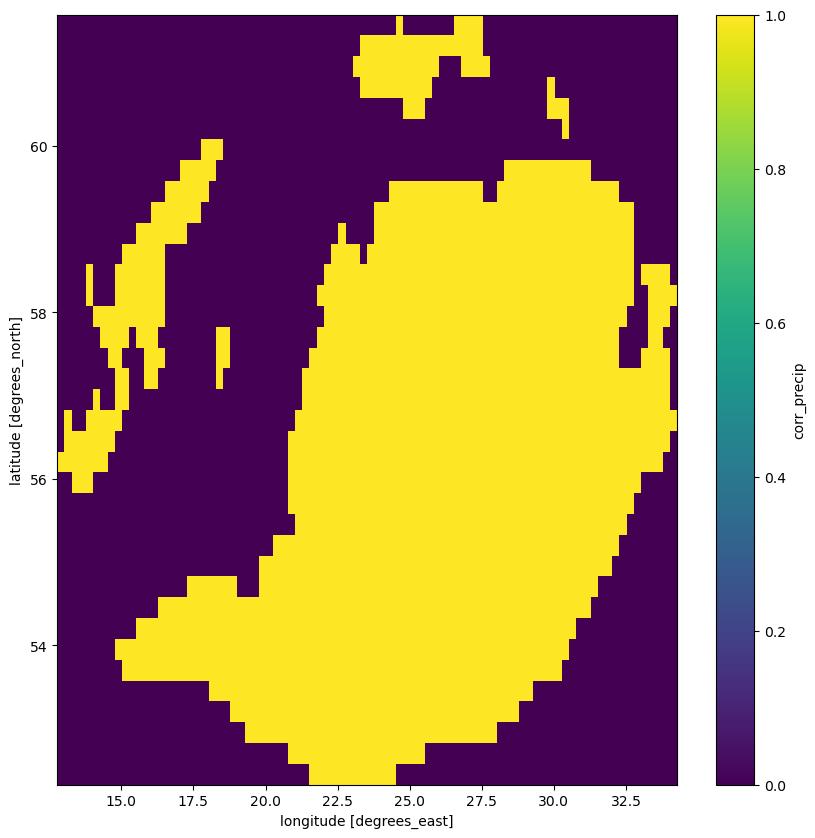

In [8]:
# create a mask of the grid cells with correlation > cutoff
mask_precip = corr_cutoff_precip.notnull()

# plot the mask
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mask_precip.plot(ax=ax)

# save the mask to a file
mask_precip.to_netcdf('./results/mask_precip.nc')

## get change values

In [38]:
models = [
     "access_cm2" , "access_esm1_5", "awi_cm_1_1_mr", "awi_esm_1_1_lr",
    "bcc_csm2_mr", "bcc_esm1", "cams_csm1_0", "canesm5",
    "canesm5_canoe", "cesm2", "cesm2_fv2", "cesm2_waccm",
    "cesm2_waccm_fv2", "ciesm", "cmcc_cm2_hr4", "cmcc_cm2_sr5",
    "cmcc_esm2", "cnrm_cm6_1", "cnrm_cm6_1_hr", "cnrm_esm2_1",
    "e3sm_1_0", "e3sm_1_1", "e3sm_1_1_eca", "ec_earth3",
    "ec_earth3_aerchem", "ec_earth3_cc", "ec_earth3_veg",
    "ec_earth3_veg_lr", "fgoals_f3_l", "fgoals_g3", "fio_esm_2_0",
    "gfdl_esm4", "giss_e2_1_g", "giss_e2_1_h", "hadgem3_gc31_ll",
    "hadgem3_gc31_mm", "iitm_esm", "inm_cm4_8", "inm_cm5_0",
    "ipsl_cm5a2_inca", "ipsl_cm6a_lr", "kace_1_0_g", "kiost_esm",
    "mcm_ua_1_0", "miroc6", "miroc_es2h", "miroc_es2l",
    "mpi_esm_1_2_ham", "mpi_esm1_2_hr", "mpi_esm1_2_lr", "mri_esm2_0",
    "nesm3", "norcpm1", "noresm2_lm", "noresm2_mm", "sam0_unicon",
    "taiesm1", "ukesm1_0_ll"
]

experiments = ['ssp1_1_9','ssp1_2_6', 'ssp2_4_5','ssp3_7_0','ssp4_3_4', 'ssp4_6_0', 'ssp5_3_4os', 'ssp5_8_5']
variables = ['precipitation', 'near_surface_air_temperature', 'precipitation_variance']
horizons = ['2021-2040', '2041-2060', '2081-2100']
seasons = ['year','DecFeb', 'MarMay', 'JunAug', 'SepNov']

### Calculate change values

In [40]:
# CV from gamma fitting functions
def get_CV_based_on_cell_average_fitting(ds_nonzero):
    na_count = 0
    CV_list = []

    for i in range(ds_nonzero.lat.shape[0]):
        for j in range(ds_nonzero.lon.shape[0]):
            try:
                # get rainfall data and filter out zero rainfall days
                rainfall_1d = ds_nonzero.pr[:,i,j].values[~np.isnan(ds_nonzero.pr[:,i,j].values)]
                shape, loc, scale = stats.gamma.fit(rainfall_1d, method='mm')
                
                CV = 1/np.sqrt(shape)
                
                #  append to list
                CV_list.append(CV)
                
            except:
                na_count += 1
                continue

    mean_CV = np.mean(CV_list)
    
    return mean_CV


def get_hist_exp_diff(ds_hist, ds_scenario, variable, season, wet_day_threshold=0.1, CV_method='cell_std_div_mean'): 
    # calculate the differences in value for the seasons

    # find month indices for the seasons
    season_months = {'year': None, 'DecFeb': 'DJF', 'MarMay': 'MAM', 'JunAug': 'JJA', 'SepNov': 'SON'}
    selected_months = season_months[season]
    
    # check if season is yearly or not
    # obtain seasonal data
    if selected_months:
        ds_hist_sel = ds_hist.sel(time=ds_hist['time.season']==selected_months)
        ds_scenario_sel = ds_scenario.sel(time=ds_scenario['time.season']==selected_months)
    
    # if season is yearly, obtain yearly data
    else:
        ds_hist_sel = ds_hist
        ds_scenario_sel = ds_scenario

    
    if variable == 'precipitation_variance':
        wet_day_threshold = 0.1/(24*60*60) # convert mm/d to kg/m²/s 
        ds_hist_sel_nonzero = ds_hist_sel.where(ds_hist_sel['pr']>wet_day_threshold)
        ds_scenario_sel_nonzero = ds_scenario_sel.where(ds_scenario_sel['pr']>wet_day_threshold)
        
        ds_hist_CV = get_CV_based_on_cell_average_fitting(ds_hist_sel_nonzero)
        ds_scenario_CV = get_CV_based_on_cell_average_fitting(ds_scenario_sel_nonzero)

        # get change in coefficient of variation
        diff_dCV = (ds_scenario_CV / ds_hist_CV - 1) * 100
        # diff_dmean = (ds_scenario_mean/ ds_hist_mean) * 100

        # return the change in CV, historical CV, and scenario CV
        return diff_dCV, ds_hist_CV, ds_scenario_CV #, diff_dmean

    if variable == 'precipitation':
        ds_hist_mean = ds_hist_sel.sum(dim=['lat', 'lon']).resample(time='Y').sum().mean()
        ds_scenario_mean = ds_scenario_sel.sum(dim=['lat', 'lon']).resample(time='Y').sum().mean()

        diff_dP = (ds_scenario_mean['pr'].values / ds_hist_mean['pr'].values - 1) * 100

        return diff_dP, float(ds_hist_mean['pr'].values), float(ds_scenario_mean['pr'].values)

    if variable == 'near_surface_air_temperature':
        ds_hist_mean = ds_hist_sel.mean(dim=['lat', 'lon']).resample(time='Y').mean().mean()
        ds_scenario_mean = ds_scenario_sel.mean(dim=['lat', 'lon']).resample(time='Y').mean().mean()

        diff_dT = ds_scenario_mean['tas'].values - ds_hist_mean['tas'].values

        return diff_dT, float(ds_hist_mean['tas'].values), float(ds_scenario_mean['tas'].values)



In [12]:
### retrieve change values for CV_std_div_mean
# dict structure: {model: {horizon: {experiment: {season: diff_P, diff_T}}}}
# generate a dict with all the data
mask_with_correlation_mask = True
CV_method = 'cell_average_fitting'
diff_dict = {}

for model in models:
    diff_dict[model] = {}
    print(model)
    for horizon in horizons:
        horizon_str = horizon.split('-')[0]
        diff_dict[model][horizon_str] = {}
        
        for experiment in experiments:
            experiment_str = experiment.replace('_', '')
            diff_dict[model][horizon_str][experiment_str] = {}
            
            for season in seasons:
                diff_dict[model][horizon_str][experiment_str][season] = {}
                diff_dict[model][horizon_str][experiment_str][season]['P'] = {}
                diff_dict[model][horizon_str][experiment_str][season]['T'] = {}
                diff_dict[model][horizon_str][experiment_str][season]['P_var'] = {}

                for variable in variables: 
                    
                    try:
                        # load data 
                        variable_to_load = variable
                        if variable == 'near_surface_air_temperature':
                            temporal_resolution = 'monthly'
                        else:
                            temporal_resolution = 'daily'
                        
                        if variable == 'precipitation_variance':
                            variable_to_load = 'precipitation'

                        ds_hist = xr.open_dataset(f'data/CDS_cmip_latvia/unzipped/CMIP6_latvia_{temporal_resolution}_historical_historical_{variable_to_load}_{model}.nc')
                        ds_scenario = xr.open_dataset(f'data/CDS_cmip_latvia/unzipped/CMIP6_latvia_{temporal_resolution}_{horizon}_{experiment}_{variable_to_load}_{model}.nc')

                        
                        # create a land mask
                        if variable == 'precipitation':
                            land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds_hist['pr'])
                            correlation_mask = xr.open_dataset('./results/mask_precip.nc')
                            correlation_mask = correlation_mask.rename({'latitude': 'lat', 'longitude': 'lon'})
                            correlation_mask_coarse = correlation_mask.interp_like(ds_hist.pr[0], method='linear')

                        elif variable == 'near_surface_air_temperature':
                            land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds_hist['tas'])
                            correlation_mask = xr.open_dataset('data/Latvia historic/mask_precip.nc')
                            correlation_mask = correlation_mask.rename({'latitude': 'lat', 'longitude': 'lon'})
                            correlation_mask_coarse = correlation_mask.interp_like(ds_hist.tas[0], method='linear')

                        elif variable == 'precipitation_variance':
                            land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds_hist['pr']) 
                            correlation_mask = xr.open_dataset('data/Latvia historic/mask_precip.nc')
                            correlation_mask = correlation_mask.rename({'latitude': 'lat', 'longitude': 'lon'})
                            correlation_mask_coarse = correlation_mask.interp_like(ds_hist.pr[0], method='linear')
                        
                        if mask_with_correlation_mask == True:
                            ds_hist = ds_hist.where(correlation_mask_coarse.corr_precip ==1)
                            ds_scenario = ds_scenario.where(correlation_mask_coarse.corr_precip ==1)
                        else:
                            ds_hist = ds_hist.where(land_mask == 0)
                            ds_scenario = ds_scenario.where(land_mask == 0)

                        if variable == 'precipitation':
                            dP, P_his, P_scenario = get_hist_exp_diff(ds_hist, ds_scenario, variable, season)
                            diff_dict[model][horizon_str][experiment_str][season]['P']['dP'] = dP
                            diff_dict[model][horizon_str][experiment_str][season]['P']['P_his'] = P_his
                            diff_dict[model][horizon_str][experiment_str][season]['P']['P_scenario'] = P_scenario
                        
                        elif variable == 'near_surface_air_temperature':
                            dT, T_his, T_scenario = get_hist_exp_diff(ds_hist, ds_scenario, variable, season)
                            diff_dict[model][horizon_str][experiment_str][season]['T']['dT'] = dT
                            diff_dict[model][horizon_str][experiment_str][season]['T']['T_his'] = T_his
                            diff_dict[model][horizon_str][experiment_str][season]['T']['T_scenario'] = T_scenario

                        elif variable == 'precipitation_variance':
                            dP_var, P_var_his, P_var_scenario = get_hist_exp_diff(ds_hist, ds_scenario, variable, season, CV_method=CV_method)
                            diff_dict[model][horizon_str][experiment_str][season]['P_var']['dP_var'] = dP_var
                            diff_dict[model][horizon_str][experiment_str][season]['P_var']['P_var_his'] = P_var_his
                            diff_dict[model][horizon_str][experiment_str][season]['P_var']['P_var_scenario'] = P_var_scenario
                    
                    except:
                        print(f'Error for {model}, {horizon}, {experiment}, {season}')
                        diff_dict[model][horizon_str][experiment_str][season]['P']['dP'] = None
                        diff_dict[model][horizon_str][experiment_str][season]['P']['P_his'] = None
                        diff_dict[model][horizon_str][experiment_str][season]['P']['P_scenario'] = None

                        diff_dict[model][horizon_str][experiment_str][season]['T']['dT'] = None
                        diff_dict[model][horizon_str][experiment_str][season]['T']['T_his'] = None
                        diff_dict[model][horizon_str][experiment_str][season]['T']['T_scenario'] = None

                        diff_dict[model][horizon_str][experiment_str][season]['P_var']['dP_var'] = None
                        diff_dict[model][horizon_str][experiment_str][season]['P_var']['P_var_his'] = None
                        diff_dict[model][horizon_str][experiment_str][season]['P_var']['P_var_scenario'] = None
                        pass


class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

with open(f'./results/Latvia_T_P_Var_scenario=all&baseline=1940-2014&landMask=true_CV_{CV_method}_mm.json', 'w') as fp:
    json.dump(diff_dict, fp, cls=NumpyEncoder, sort_keys=False, indent=4, separators=(',', ': '))

access_cm2
Error for access_cm2, 2021-2040, ssp1_1_9, year
Error for access_cm2, 2021-2040, ssp1_1_9, year
Error for access_cm2, 2021-2040, ssp1_1_9, year
Error for access_cm2, 2021-2040, ssp1_1_9, DecFeb
Error for access_cm2, 2021-2040, ssp1_1_9, DecFeb
Error for access_cm2, 2021-2040, ssp1_1_9, DecFeb
Error for access_cm2, 2021-2040, ssp1_1_9, MarMay
Error for access_cm2, 2021-2040, ssp1_1_9, MarMay
Error for access_cm2, 2021-2040, ssp1_1_9, MarMay
Error for access_cm2, 2021-2040, ssp1_1_9, JunAug
Error for access_cm2, 2021-2040, ssp1_1_9, JunAug
Error for access_cm2, 2021-2040, ssp1_1_9, JunAug
Error for access_cm2, 2021-2040, ssp1_1_9, SepNov
Error for access_cm2, 2021-2040, ssp1_1_9, SepNov
Error for access_cm2, 2021-2040, ssp1_1_9, SepNov
Error for access_cm2, 2021-2040, ssp4_3_4, year
Error for access_cm2, 2021-2040, ssp4_3_4, year
Error for access_cm2, 2021-2040, ssp4_3_4, year
Error for access_cm2, 2021-2040, ssp4_3_4, DecFeb
Error for access_cm2, 2021-2040, ssp4_3_4, DecFeb
E

In [ ]:
diff_dict

{'access_cm2': {'2021': {'ssp119': {'year': {'P': {'dP': None,
      'P_his': None,
      'P_scenario': None},
     'T': {'dT': None, 'T_his': None, 'T_scenario': None},
     'P_var': {'dP_var': None, 'P_var_his': None, 'P_var_scenario': None}},
    'DecFeb': {'P': {'dP': None, 'P_his': None, 'P_scenario': None},
     'T': {'dT': None, 'T_his': None, 'T_scenario': None},
     'P_var': {'dP_var': None, 'P_var_his': None, 'P_var_scenario': None}},
    'MarMay': {'P': {'dP': None, 'P_his': None, 'P_scenario': None},
     'T': {'dT': None, 'T_his': None, 'T_scenario': None},
     'P_var': {'dP_var': None, 'P_var_his': None, 'P_var_scenario': None}},
    'JunAug': {'P': {'dP': None, 'P_his': None, 'P_scenario': None},
     'T': {'dT': None, 'T_his': None, 'T_scenario': None},
     'P_var': {'dP_var': None, 'P_var_his': None, 'P_var_scenario': None}},
    'SepNov': {'P': {'dP': None, 'P_his': None, 'P_scenario': None},
     'T': {'dT': None, 'T_his': None, 'T_scenario': None},
     'P_var': 

### convert to CSV

In [15]:
region = 'Latvia'
baseline = '1940-2014'
metrics = "T_P_Var" # T_P_Var
CV_method = "_CV_cell_average_fitting_mm"# "", ['_CV_cell_std_div_mean', '_CV_basin_wide_std_div_mean', '_CV_basin_daily_sum_std_and_mean', '_CV_cell_average_fitting_mle', '_CV_basin_wide_rainfall_fitting_mle', '_CV_cell_average_fitting_mm', _CV_basin_wide_rainfall_fitting_mm]

# open model_dict file
data_path = f"results/{region}_{metrics}_scenario=all&baseline={baseline}&landMask=true{CV_method}.json" #'results/all_ssp_horizons_models_seasons_dict.json'

with open(data_path) as json_file:
    model_dict = json.load(json_file)

# convert the second sub-dict to integer keys (time horizons)
for k,v in model_dict.items():
    model_dict[k] = {int(k2):v2 for k2,v2 in v.items()}

In [16]:
seasons = ['year', 'DecFeb', 'MarMay', 'JunAug', 'SepNov'] #  ['year', 'DecFeb', 'MarMay', 'JunAug', 'SepNov']
ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585'] # ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534os', 'ssp585']
dates= [2021, 2041, 2081] # [2021, 2041,2081]

In [17]:
# create a dataframe with model names as index and dT and dP as columns
columns = []

for season in seasons:
    for key in model_dict['access_cm2'][2021]['ssp126'][season].keys():
        columns.append(f'{season}_{key}')

df_1ssp_1date = pd.DataFrame()

ssp = ssps[0]
year = dates[0]

for model in model_dict:
    dT_values = np.array([])
    dP_values = np.array([])
    for season in seasons:
        dT_value = model_dict[model][year][ssp][season]['T']["dT"]
        dP_value = model_dict[model][year][ssp][season]['P']["dP"]

        # print(model, season, dT_value, dP_value)
        df_1ssp_1date.loc[model, f'{season}_dT'] = dT_value
        df_1ssp_1date.loc[model, f'{season}_dP'] = dP_value

df_all = pd.DataFrame(columns=df_1ssp_1date.columns)

for model in model_dict:
    for date in dates:
        for ssp in ssps:
            for season in seasons:
                dT_value = model_dict[model][date][ssp][season]['T']["dT"]
                dP_value = model_dict[model][date][ssp][season]['P']["dP"]
                dP_var_value = model_dict[model][date][ssp][season]['P_var']["dP_var"]

                # print(model, season, dT_value, dP_value)
                df_all.loc[f'{model}_{ssp}_{date}', f'{season}_dT'] = dT_value
                df_all.loc[f'{model}_{ssp}_{date}', f'{season}_dP'] = dP_value
                df_all.loc[f'{model}_{ssp}_{date}', f'{season}_dP_var'] = dP_var_value

# save to csv
df_all.to_csv(f'results/{region}_all_models_dT_dP_dP_var.csv')
    

### plot change values

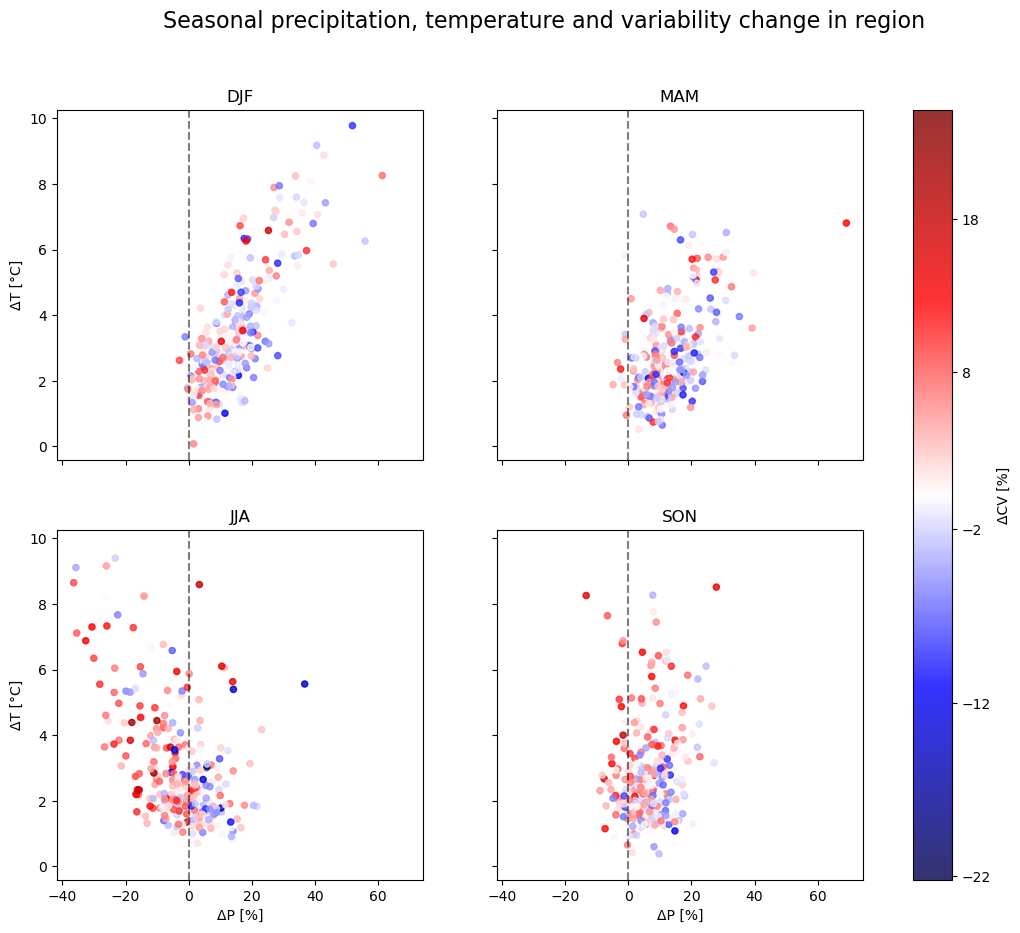

In [18]:
# Create a colormap
cmap = plt.get_cmap('seismic')

# Get the min and max values for all seasons
vmin = df_all[['JunAug_dP_var', 'MarMay_dP_var', 'SepNov_dP_var', 'DecFeb_dP_var']].min().min()
vmax = df_all[['JunAug_dP_var', 'MarMay_dP_var', 'SepNov_dP_var', 'DecFeb_dP_var']].max().max()

# Create a TwoSlopeNorm object
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# plot four seasons dp dt scatter
fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharex=True, sharey=True)

# Add _dP_var as colormap using TwoSlopeNorm normalization
# scatter0 = df_all.plot.scatter(x='year_dP', y='year_dT', c='year_dP_var', cmap=cmap, alpha=0.6, zorder=2, ax=ax[0][0], colorbar=False, norm=norm)
scatter4 = df_all.plot.scatter(x='DecFeb_dP', y='DecFeb_dT', c='DecFeb_dP_var', cmap=cmap, alpha=0.8, zorder=2, ax=ax[0][0], colorbar=False, norm=norm)
scatter2 = df_all.plot.scatter(x='MarMay_dP', y='MarMay_dT', c='MarMay_dP_var', cmap=cmap, alpha=0.8, zorder=2, ax=ax[0][1], colorbar=False, norm=norm)
scatter1 = df_all.plot.scatter(x='JunAug_dP', y='JunAug_dT', c='JunAug_dP_var', cmap=cmap, alpha=0.8, zorder=2, ax=ax[1][0], colorbar=False, norm=norm)
scatter3 = df_all.plot.scatter(x='SepNov_dP', y='SepNov_dT', c='SepNov_dP_var', cmap=cmap, alpha=0.8, zorder=2, ax=ax[1][1], colorbar=False, norm=norm)

# Display the colorbar
fig.colorbar(scatter4.get_children()[0], ax=ax, orientation='vertical', label='ΔCV [%]', ticks=np.arange(int(vmin), int(vmax), 10))

# Your existing code
plt.suptitle(f'Seasonal precipitation, temperature and variability change in region', fontsize=16)

# set vline at 0
# ax[0][0].axvline(0, color='black', linestyle='--', alpha=0.5)
ax[0][0].axvline(0, color='black', linestyle='--', alpha=0.5)
ax[0][1].axvline(0, color='black', linestyle='--', alpha=0.5)
ax[1][0].axvline(0, color='black', linestyle='--', alpha=0.5)
ax[1][1].axvline(0, color='black', linestyle='--', alpha=0.5)

# ax[0][0].set_title('Annual')
ax[0][0].set_title('DJF')
ax[0][1].set_title('MAM')
ax[1][0].set_title('JJA')
ax[1][1].set_title('SON')

# ax[0][0].set_ylabel('dT [°C]')
ax[1][0].set_ylabel('ΔT [°C]')
ax[0][0].set_ylabel('ΔT [°C]')
ax[1][0].set_xlabel('ΔP [%]')
ax[1][1].set_xlabel('ΔP [%]')
ax[0][0].set_xlabel('ΔP [%]')
ax[0][1].set_xlabel('ΔP [%]')

plt.show()


In [19]:

# per season find the min and max of dP_var, dP and dT and store the ranges in a dataframe
df_ranges = pd.DataFrame(columns=['dT_min', 'dT_max', 'dP_min', 'dP_max', 'dP_var_min', 'dP_var_max'])
seasons = ['DecFeb', 'MarMay', 'JunAug', 'SepNov']
for season in seasons:
    df_ranges.loc[season, 'dT_min'] = df_all[f'{season}_dT'].min()
    df_ranges.loc[season, 'dT_max'] = df_all[f'{season}_dT'].max()
    df_ranges.loc[season, 'dP_min'] = df_all[f'{season}_dP'].min()
    df_ranges.loc[season, 'dP_max'] = df_all[f'{season}_dP'].max()
    df_ranges.loc[season, 'dP_var_min'] = df_all[f'{season}_dP_var'].min()
    df_ranges.loc[season, 'dP_var_max'] = df_all[f'{season}_dP_var'].max()

df_ranges

,dT_min,dT_max,dP_min,dP_max,dP_var_min,dP_var_max
DecFeb,0.081848,9.781586,-2.964175,61.312199,-11.214331,16.752312
MarMay,0.519684,7.081024,-4.845297,69.068265,-12.720768,16.622332
JunAug,0.711151,9.400421,-36.449581,36.748958,-22.203807,22.240969
SepNov,0.385956,8.517426,-13.820851,32.568419,-11.479631,25.158963
